In [1]:
import pandas as pd

import collections

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def plot_neighbourhood(node, G, candidates, labels=False):
    # plot the neighbourhood of the top node ENSG00000101773
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]

    sub_G = nx.Graph(sub_G) # unfreeze the graph
    sub_G.remove_edges_from(nx.selfloop_edges(sub_G)) # removing self-loops

    color_map = ['orangered' if node in candidates_in_neighbourhood else 'lightblue' for node in sub_G]
    pos=nx.spring_layout(sub_G)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.set_title(f"Neighbourhood of {node}")
    nx.draw_networkx(sub_G, pos=pos, with_labels=False, node_size=100, alpha=0.9, ax=ax, node_color=color_map)

    if labels:
        # plot candidates labels
        labels = {}
        for node in sub_G.nodes():
            if node in candidates_in_neighbourhood:
                labels[node] = node

        pos_higher = {}
        for k, v in pos.items():
            if(v[1]>0):
                pos_higher[k] = (v[0]-0.1, v[1]+0.1)
            else:
                pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        nx.draw_networkx_labels(sub_G, pos=pos_higher, labels=labels, font_size=10, font_color='tomato')
    
    _ = ax.axis('off')

In [3]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_MMAF.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

### Analyze interactome

In [4]:
# number of proteins
len(G.nodes())

10215

In [5]:
# number of interactions
G.number_of_edges()

42351

Text(0, 0.5, 'number of nodes')

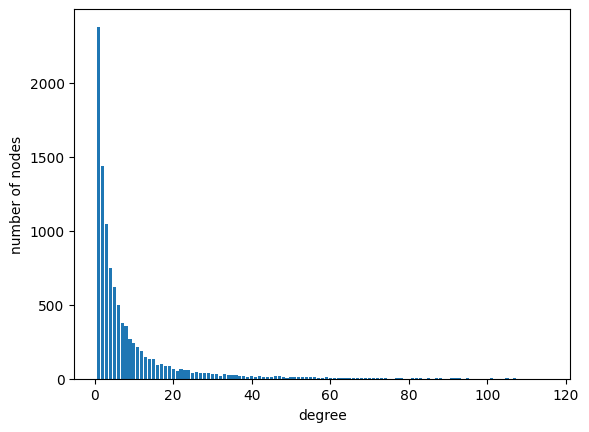

In [6]:
# degree histogram
degrees = sorted([d for n, d in G.degree()])
deg, cnt = zip(*collections.Counter(degrees).items())

plt.bar(deg, cnt)
plt.xlabel("degree")
plt.ylabel("number of nodes")

In [7]:
# average degree
sum([d for _, d in G.degree()]) / G.number_of_nodes()

8.291923641703377

### Count candidate genes for each node neighbourhood

In [8]:
# count candidate genes for each node
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = candidates_in_neighbourhood_cnt

In [9]:
s = pd.Series(d, name='# candidates in neighbourhood')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000158104    1
ENSG00000065559    0
ENSG00000088970    0
ENSG00000167578    0
ENSG00000128654    0
                  ..
ENSG00000198785    0
ENSG00000172115    0
ENSG00000204420    0
ENSG00000121966    0
ENSG00000137767    0
Name: # candidates in neighbourhood, Length: 10215, dtype: int64

Text(0, 0.5, 'number of nodes')

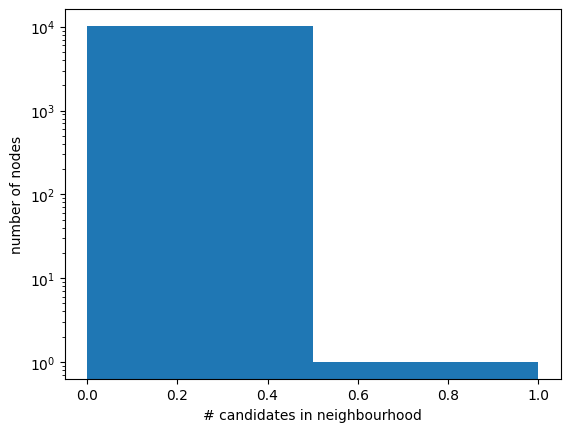

In [10]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
ax.set_xlabel("# candidates in neighbourhood")
ax.set_ylabel("number of nodes")

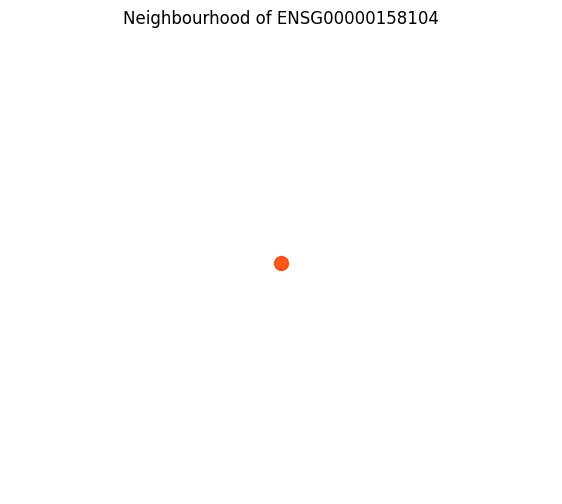

In [12]:
plot_neighbourhood("ENSG00000158104", G, candidates, labels=False)

Information about ENSG00000101773:

Gene RBBP8

Protein Q99708 (endonuclease - DSB repair through HR; component of BRCA1-RBBP8)

In [13]:
# relation between the number of candidate genes vs degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = [candidates_in_neighbourhood_cnt, G.degree(node)]

df = pd.DataFrame.from_dict(d, orient='index', columns=['# candidates in neighbourhood', 'degree'])

<Axes: xlabel='degree', ylabel='# candidates in neighbourhood'>

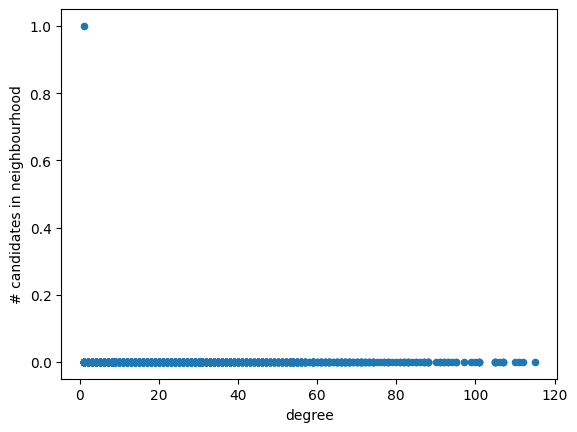

In [14]:
df.plot.scatter(x='degree', y='# candidates in neighbourhood')

In [15]:
# fraction of candidates that are present in interactome
len([candidate for candidate in candidates if candidate in G.nodes()]) / len(candidates)

# ~50% means that the second half of candidate genes has been filtered out during the building of interactome (e.g. because they form hubs >120 connections)

0.1111111111111111

In [16]:
# average degree of infertility candidate genes
d = {}

for node in G.nodes():
    if node in candidates:
        d[node] = G.degree(node)

sum([deg for n, deg in d.items()]) / len(d.keys())

1.0

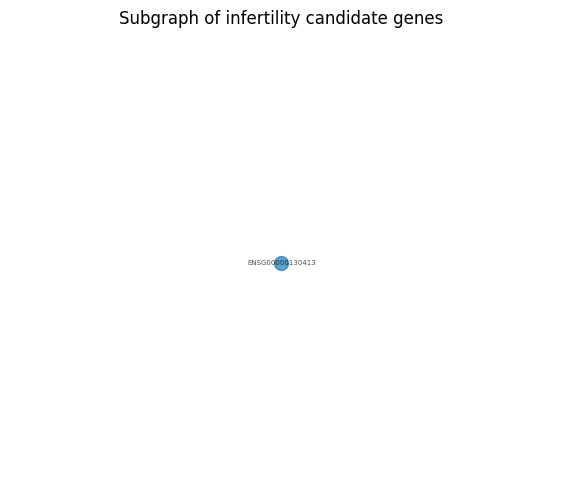

In [17]:
# subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])

candidates_sub_G = nx.Graph(candidates_sub_G) # unfreeze the graph
candidates_sub_G.remove_edges_from(nx.selfloop_edges(candidates_sub_G)) # removing self-loops

plt.figure(figsize=(7, 6))
ax = plt.gca()
ax.set_title(f"Subgraph of infertility candidate genes")
# nx.draw_networkx(candidates_sub_G, with_labels=False, node_size=100, alpha=0.9, ax=ax)
nx.draw_circular(candidates_sub_G, with_labels=True, node_size=100, alpha=0.7, ax=ax, font_size=5)
_ = ax.axis('off')

In [18]:
# number of nodes and edges in subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])
candidates_sub_G.number_of_nodes(), candidates_sub_G.number_of_edges()

(1, 0)

### Score 1: Count candidate genes for each node and divide by node degree

In [19]:
# count candidate genes for each node and divide by node degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = candidates_in_neighbourhood_cnt / G.degree(node)

In [20]:
s = pd.Series(d, name='Score 1')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000158104    1.0
ENSG00000065559    0.0
ENSG00000088970    0.0
ENSG00000167578    0.0
ENSG00000128654    0.0
                  ... 
ENSG00000198785    0.0
ENSG00000172115    0.0
ENSG00000204420    0.0
ENSG00000121966    0.0
ENSG00000137767    0.0
Name: Score 1, Length: 10215, dtype: float64

Text(0, 0.5, 'number of nodes')

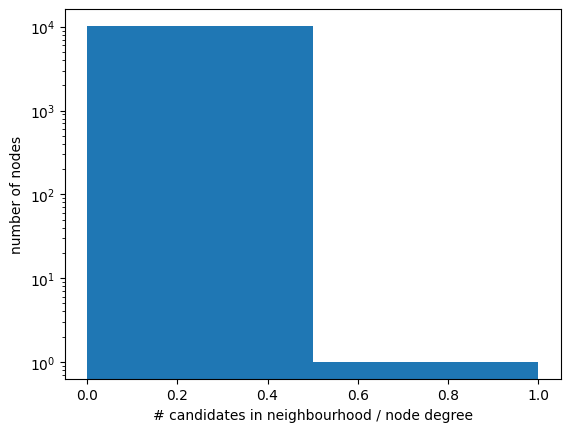

In [21]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
# ax = s[s>0].plot.hist(bins=len(set(s.values)))
ax.set_xlabel("# candidates in neighbourhood / node degree")
ax.set_ylabel("number of nodes")

In [22]:
# same as above, but get more node info

# count candidate genes for each node and divide by node degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)

    isCandidate = True if node in candidates else False

    # calculate score 1
    score = candidates_in_neighbourhood_cnt / G.degree(node)

    d[node] = [score, candidates_in_neighbourhood_cnt, G.degree(node), isCandidate]

In [23]:
df = pd.DataFrame.from_dict(d, orient='index', columns=['score 1', '# candidates in neighbourhood', 'degree', 'isCandidate'])
df[df['degree'] > 10].sort_values(by='score 1', ascending=False).head()

,score 1,# candidates in neighbourhood,degree,isCandidate
ENSG00000128591,0.0,0,13,False
ENSG00000197694,0.0,0,29,False
ENSG00000151849,0.0,0,26,False
ENSG00000172179,0.0,0,15,False
ENSG00000243646,0.0,0,15,False


In [24]:
df[(df['score 1'] != 0) & (df['degree'] > 5)].sort_values(by='score 1', ascending=False).head()

,score 1,# candidates in neighbourhood,degree,isCandidate


### Score 2: 